## Packages & helper functions

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pymongo import MongoClient

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix

In [25]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

In [26]:
def plot_cm(y_true, y_pred, figsize=(6,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

## 1 - Prepare data

In [27]:
data = pd.read_csv('raw_data.csv')
data.head(30)

,content,category
0,“Bà Phương Hằng bị kiện đòi bồi thường 1.000 t...,Phương Hằng
1,"""Bà Phương Hằng cam kết thôi, không livestream...",Phương Hằng
2,"“Bà Phương Hằng ""hứa sẽ trở lại vào tuần sau""....",Phương Hằng
3,“Đàm Vĩnh Hưng 'đáp trả' bà Nguyễn Phương Hằng...,Phương Hằng
4,"“Bà Nguyễn Phương Hằng bị phạt 7,5 triệu đồng ...",Phương Hằng
5,“Đại diện của bà Phương Hằng giải trình tại bu...,Phương Hằng
6,"“Bà Phương Hằng đã nói gì với đại gia Dũng ""lò...",Phương Hằng
7,“Bà Phương Hằng viết tâm thư như muốn dừng cuộ...,Phương Hằng
8,“Bà Phương Hằng nói về vụ từ thiện 13 tỷ của H...,Phương Hằng
9,“Bà Phương Hằng chính thức lên tiếng làm rõ vì...,Phương Hằng


In [28]:
data.groupby('category').size()

category
Covid           10
Donald Trump    10
Phương Hằng     10
dtype: int64

## 2 - Apply TF-IDF on text

In [29]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['content']).toarray()
vocab = vectorizer.get_feature_names()

In [30]:
X

array([[0.04385901, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02940369],
       [0.        , 0.        , 0.        , ..., 0.0162765 , 0.        ,
        0.        ]])

## 3 - Cluster data by k-means

### 3.1. Tìm số clusters tối ưu bằng   Elbow Method

Có tổng cộng 10 bài báo cho mỗi thể loại "Covid" / "Donald Trump" / "Phương Hằng". Bởi vậy, số cluster tối ưu mà chúng ta mong muốn sẽ là 3, cũng là số thể loại.

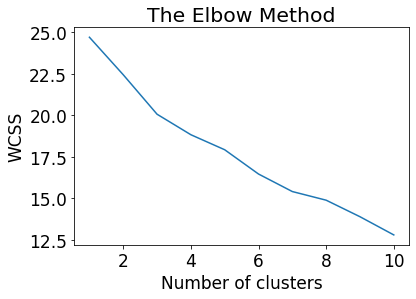

In [31]:
wcss = []
num = 11
for i in range(1,num): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 500, n_init = 1, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,num), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Từ đồ thị trên, thật khó để xác định số lượng cluster tối ưu cho tập dữ liệu trên. Tuy nhiên, chúng ta sẽ sử dụng `n_clusters = 3` để giải quyết các bước tiếp theo.

### 3.2. Apply k-means with n_clusters = 3

In [32]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, n_init = 3, random_state = 0)
y_kmeans = kmeans.fit_predict(X)
y_kmeans

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [33]:
def categorize(row):
    if row["kmeans_cluster"] == 0:
        return "Phương Hằng"
    elif row["kmeans_cluster"] == 1:
        return "Donald Trump"
    else:
        return "Covid"

data["kmeans_cluster"] = y_kmeans
data["kmeans_label"] = data.apply(lambda row: categorize(row), axis=1)
data

,content,category,kmeans_cluster,kmeans_label
0,“Bà Phương Hằng bị kiện đòi bồi thường 1.000 t...,Phương Hằng,0,Phương Hằng
1,"""Bà Phương Hằng cam kết thôi, không livestream...",Phương Hằng,0,Phương Hằng
2,"“Bà Phương Hằng ""hứa sẽ trở lại vào tuần sau""....",Phương Hằng,0,Phương Hằng
3,“Đàm Vĩnh Hưng 'đáp trả' bà Nguyễn Phương Hằng...,Phương Hằng,0,Phương Hằng
4,"“Bà Nguyễn Phương Hằng bị phạt 7,5 triệu đồng ...",Phương Hằng,0,Phương Hằng
5,“Đại diện của bà Phương Hằng giải trình tại bu...,Phương Hằng,0,Phương Hằng
6,"“Bà Phương Hằng đã nói gì với đại gia Dũng ""lò...",Phương Hằng,0,Phương Hằng
7,“Bà Phương Hằng viết tâm thư như muốn dừng cuộ...,Phương Hằng,0,Phương Hằng
8,“Bà Phương Hằng nói về vụ từ thiện 13 tỷ của H...,Phương Hằng,0,Phương Hằng
9,“Bà Phương Hằng chính thức lên tiếng làm rõ vì...,Phương Hằng,0,Phương Hằng


In [34]:
confusion_matrix(data["category"], data["kmeans_label"])

array([[10,  0,  0],
       [ 0, 10,  0],
       [ 0,  0, 10]])

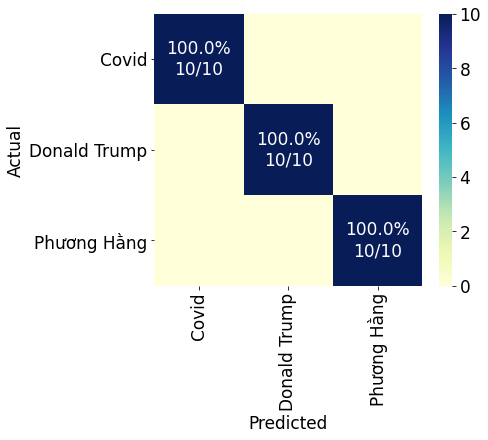

In [23]:
plot_cm(data["category"], data["kmeans_label"])